In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cPickle as pickle

In [2]:
train_data = pd.read_csv('./rl_train_set_small.csv')

In [3]:
test_data = pd.read_csv('./rl_test_set_small.csv')

In [30]:
test_data.keys()

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1.1', u'bloc',
       u'icustayid', u'charttime', u'gender', u'age', u'elixhauser',
       u're_admission', u'died_in_hosp', u'mortality_90d', u'Weight_kg',
       u'GCS', u'HR', u'SysBP', u'MeanBP', u'DiaBP', u'Shock_Index', u'RR',
       u'SpO2', u'Temp_C', u'FiO2_1', u'Potassium', u'Sodium', u'Chloride',
       u'Glucose', u'BUN', u'Creatinine', u'Magnesium', u'Calcium',
       u'Ionised_Ca', u'CO2_mEqL', u'SGOT', u'SGPT', u'Total_bili', u'Albumin',
       u'Hb', u'WBC_count', u'Platelets_count', u'PTT', u'PT', u'INR',
       u'Arterial_pH', u'paO2', u'paCO2', u'Arterial_BE', u'Arterial_lactate',
       u'HCO3', u'PaO2_FiO2', u'mechvent', u'SOFA', u'SIRS',
       u'median_dose_vaso', u'max_dose_vaso', u'input_total_tev',
       u'input_4hourly_tev', u'output_total', u'output_4hourly',
       u'cumulated_balance_tev', u'vaso_input', u'iv_input', u'reward'],
      dtype='object')

In [4]:
def preproc(df_in, iv_bins = 5):
    df = df_in.copy()
    actions_raw = df[['iv_input', 'vaso_input']].values
    keep_arr = np.loadtxt('./state_vector.txt', dtype=str)
    df = df[keep_arr]
    actions_proc = (iv_bins*actions_raw[:, 0] + actions_raw[:, 1]).astype(int)
    hist = np.histogram(actions_proc, 25)
    actions_proc = pd.get_dummies(actions_proc).values
    #print(hist) just to check
    return df.values, actions_proc

In [5]:
def batch_sample(batch_len, features, labels):
    idx = np.random.choice(np.arange(len(features)), batch_len)
    return (np.vstack(features[idx]), np.vstack(labels[idx]))

In [6]:
train_feat, train_labels = preproc(train_data)
test_feat, test_labels = preproc(test_data)

In [8]:
feature_length = len(train_feat[0])
batch_size = 100
num_actions = 25
num_steps = 50000

In [9]:
class PolicyModel():
    def __init__(self):
        self.input_feat = tf.placeholder(tf.float32, shape = [None, feature_length])
        self.labels = tf.placeholder(tf.float32, shape = [None, num_actions])
        self.phase = tf.placeholder(tf.bool)
        
#         self.fc_1 = tf.contrib.layers.fully_connected(self.input_feat, 128, activation_fn=tf.nn.relu)
#         self.bn_1 = tf.contrib.layers.batch_norm(self.fc_1, center=True, scale=True, is_training=self.phase)
#         self.fc_2 = tf.contrib.layers.fully_connected(self.fc_1 , 128, activation_fn=tf.nn.relu)
#         self.bn_2 = tf.contrib.layers.batch_norm(self.fc_2, center=True, scale=True, is_training=self.phase)
        
        
        self.fc_1 = tf.contrib.layers.fully_connected(self.input_feat, 1000, activation_fn=tf.nn.relu)
        self.bn_1 = tf.contrib.layers.batch_norm(self.fc_1, center=True, scale=True, is_training=self.phase)
        self.fc_2 = tf.contrib.layers.fully_connected(self.bn_1 , 500, activation_fn=tf.nn.relu)    
        self.bn_2 = tf.contrib.layers.batch_norm(self.fc_2, center=True, scale=True, is_training=self.phase)
        self.fc_3 = tf.contrib.layers.fully_connected(self.bn_2 , 300, activation_fn=tf.nn.relu)
        self.bn_3 = tf.contrib.layers.batch_norm(self.fc_3, center=True, scale=True, is_training=self.phase)
        self.fc_4 = tf.contrib.layers.fully_connected(self.bn_3 , 150, activation_fn=tf.nn.relu)
        self.bn_4 = tf.contrib.layers.batch_norm(self.fc_4, center=True, scale=True, is_training=self.phase)
        
        self.logits = tf.contrib.layers.fully_connected(self.bn_4 , num_actions, activation_fn=None)
        self.output = tf.nn.softmax(self.logits)
        self.reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        self.reg_constant = 0.01 
        
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.labels, 1), tf.argmax(self.output, 1)),'float32'))
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.labels)) + self.reg_constant*sum(self.reg_losses)

        
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
            self.train_step = tf.train.AdamOptimizer().minimize(self.loss)

In [10]:
def train():
    tf.reset_default_graph()
    mdl = PolicyModel()
    config = tf.ConfigProto()
    init = tf.global_variables_initializer()
    with tf.Session(config=config) as sess:
        sess.run(init)
        i = 0
        net_loss = 0
        net_accuracy = 0.0
        print('Starting training!')
        for i in range(num_steps):
            i+=1
            feat, labels = batch_sample(batch_size, train_feat, train_labels)
            
            _, loss, accuracy = sess.run([mdl.train_step, mdl.loss, mdl.accuracy], feed_dict={mdl.input_feat : feat, mdl.labels: labels, mdl.phase: 1})
            
            net_loss += loss
            net_accuracy += accuracy
            if i % 1000 == 0 and i > 0:
                av_loss = net_loss/1000.0
                av_accuracy = net_accuracy/1000.0
                print("Step: ", i, "Average loss is: ", av_loss, "Average accuracy is: ", av_accuracy)
                net_loss = 0.0
                net_accuracy = 0.0
                
        op = np.zeros((len(test_feat), num_actions))
        total_acc = 0
        j = 0
        while (j < len(test_feat)):
            feat = None
            labels = None
            if len(test_feat) - j < batch_size:
                feat = test_feat[j:-1]
                lbls = test_labels[j:-1]
            else:
                feat = test_feat[j:j+batch_size]
                lbls = test_labels[j:j+batch_size]
            feat = feat.reshape(len(feat), feature_length)
            lbls = lbls.reshape(len(lbls), num_actions)
            if j%10000 == 0: print('Processing test set indx: ', j )
            softmax, accuracy = sess.run([mdl.output, mdl.accuracy], feed_dict={mdl.input_feat : feat, mdl.phase: 0, mdl.labels: lbls, mdl.phase: 0})
            total_acc += accuracy
            op[j:j+len(feat)] = softmax
            if len(test_feat) - j < batch_size:
                j = len(test_feat)
            else: j+=batch_size
    print('Final accuracy on test: ', total_acc/(len(op)/batch_size))
    return op


In [50]:
op = train()

Starting training!
('Step: ', 1000, 'Average loss is: ', 1.9168550771474839, 'Average accuracy is: ', 0.33235000203549864)
('Step: ', 2000, 'Average loss is: ', 1.6933085815906526, 'Average accuracy is: ', 0.36175000050663947)
('Step: ', 3000, 'Average loss is: ', 1.6561540344953536, 'Average accuracy is: ', 0.37072999975085258)
('Step: ', 4000, 'Average loss is: ', 1.6228221287727356, 'Average accuracy is: ', 0.38398999892175195)
('Step: ', 5000, 'Average loss is: ', 1.595211664557457, 'Average accuracy is: ', 0.39240999887883665)
('Step: ', 6000, 'Average loss is: ', 1.5659543656110764, 'Average accuracy is: ', 0.4044099981188774)
('Step: ', 7000, 'Average loss is: ', 1.537966688990593, 'Average accuracy is: ', 0.41733999821543694)
('Step: ', 8000, 'Average loss is: ', 1.5096219664812087, 'Average accuracy is: ', 0.42986999785900115)
('Step: ', 9000, 'Average loss is: ', 1.4769313097000123, 'Average accuracy is: ', 0.44551999789476393)
('Step: ', 10000, 'Average loss is: ', 1.4544493

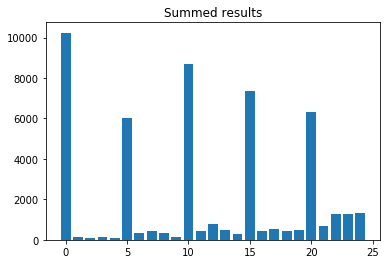

In [51]:
p_sum = np.sum(op, axis = 0)
plt.bar(np.arange(25), p_sum)
plt.title('Summed results')
plt.show()

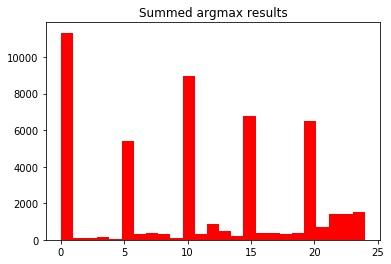

0.23219116321


In [52]:
arg_op = np.argmax(op, axis = 1)
plt.hist(arg_op, bins=25, color = 'red')
plt.title('Summed argmax results')
plt.show()
print(float(sum((arg_op==0).astype(int)))/len(arg_op))

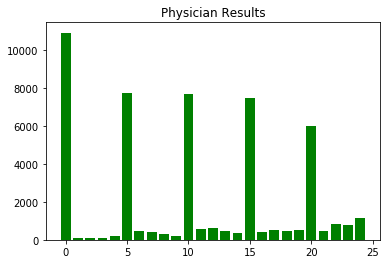

In [53]:
plt.bar(np.arange(25), np.sum(test_labels, axis = 0), color = 'green')
plt.title('Physician Results')
plt.show()

In [54]:
print(op[323])
print(test_labels[2828])

[  5.41581213e-01   2.31197816e-07   7.97078101e-08   2.69315361e-08
   1.23382247e-08   2.52103537e-01   1.41979399e-07   2.35948846e-06
   8.82338380e-09   9.20470526e-08   7.55063817e-02   1.54136792e-08
   1.10307511e-07   1.36421212e-08   9.92609372e-09   3.18774581e-02
   1.50501691e-07   3.52516764e-07   1.88777534e-07   9.62132507e-09
   9.89109054e-02   1.42019758e-07   1.61423959e-05   3.70182761e-07
   5.03764745e-08]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [69]:
t_data = test_data[['icustayid', 'bloc', 'iv_input', 'vaso_input']].values
actions_proc = (5*test_data['iv_input'].values + test_data['vaso_input']).values.astype(int)
to_pickle = np.concatenate((t_data, actions_proc.reshape(len(actions_proc), 1), op), axis = 1)

In [70]:
print(to_pickle[0])

[  1.40000000e+01   1.00000000e+00   4.00000000e+00   0.00000000e+00
   2.00000000e+01   1.13310514e-03   4.81757212e-09   2.74552492e-09
   8.32415692e-10   4.58256696e-13   2.31465790e-03   3.08822223e-07
   1.20316244e-07   2.08486824e-07   1.35711287e-09   4.57575589e-01
   3.16393681e-07   2.73115916e-07   7.89537502e-09   2.45633736e-08
   2.39331558e-01   4.33557084e-08   5.36875268e-06   1.70210990e-09
   2.09625914e-10   2.99623281e-01   1.10643022e-07   3.07074697e-06
   2.12497616e-06   9.80412096e-06]


In [73]:
with open(r"data.pickle", "wb") as output_file:
    pickle.dump(to_pickle, output_file)